## Imports

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process import *


df = pd.read_csv('gp_objects(downsample).csv')
obj = sorted(df.obj_id.unique())
df_observed = pd.read_csv('gp_objects_original_observations(matched).csv')
df_observed = df_observed[df_observed.obj_id.isin(obj)]
display(df)
display(df_observed)
common_columns = ['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
    'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
    'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',]

,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,...,abs_mag_ztfi,mag_error_ztfi,flux_ztfg,flux_error_ztfg,flux_ztfr,flux_error_ztfr,flux_ztfi,flux_error_ztfi,rise,fade
0,ZTF18aakuewf,Ibn,0.0636,58226.340532,58226.340532,0.000000,18.516426,-13.834339,0.235213,18.914558,...,NaN,NaN,142.373588,30.843697,98.668109,1.246373,NaN,NaN,y,y
1,ZTF18aakuewf,Ibn,0.0636,58226.390513,58226.340532,0.049981,18.496472,-13.854294,0.224712,18.882957,...,NaN,NaN,145.014457,30.013242,101.582057,1.080243,NaN,NaN,y,y
2,ZTF18aakuewf,Ibn,0.0636,58226.440494,58226.340532,0.099961,18.476866,-13.873900,0.214622,18.852310,...,NaN,NaN,147.656847,29.187955,104.490322,1.080575,NaN,NaN,y,y
3,ZTF18aakuewf,Ibn,0.0636,58226.490474,58226.340532,0.149942,18.457598,-13.893168,0.204923,18.822692,...,NaN,NaN,150.300692,28.367979,107.379974,1.219787,NaN,NaN,y,y
4,ZTF18aakuewf,Ibn,0.0636,58226.540455,58226.340532,0.199923,18.438655,-13.912110,0.195597,18.794102,...,NaN,NaN,152.945927,27.553467,110.245034,1.433721,NaN,NaN,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36853,ZTF24aascytf,II,0.0380,60480.172223,60476.217836,3.954388,20.793887,-10.398977,1.026317,20.312205,...,-11.090834,0.700057,17.476125,16.519709,27.234410,15.860492,33.051259,21.310669,y,y
36854,ZTF24aascytf,II,0.0380,60480.181356,60476.217836,3.963520,20.795950,-10.396914,1.034748,20.315167,...,-11.087963,0.703241,17.442947,16.623801,27.160225,15.918773,32.963971,21.351059,y,y
36855,ZTF24aascytf,II,0.0380,60480.190488,60476.217836,3.972653,20.797930,-10.394934,1.043002,20.318076,...,-11.085116,0.706375,17.411165,16.725866,27.087546,15.974491,32.877653,21.390053,y,y
36856,ZTF24aascytf,II,0.0380,60480.199621,60476.217836,3.981785,20.799828,-10.393036,1.051076,20.320933,...,-11.082294,0.709458,17.380760,16.825905,27.016360,16.027639,32.792302,21.427639,y,y


,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi
0,ZTF18aakuewf,Ibn,0.0636,58226.340532,58226.340532,0.000000,NaN,NaN,NaN,18.961000,-13.389765,0.031726,NaN,NaN,NaN
1,ZTF18aakuewf,Ibn,0.0636,58226.358623,58226.340532,0.018090,NaN,NaN,NaN,18.871901,-13.478865,0.029414,NaN,NaN,NaN
2,ZTF18aakuewf,Ibn,0.0636,58226.378947,58226.340532,0.038414,NaN,NaN,NaN,18.922800,-13.427966,0.033493,NaN,NaN,NaN
3,ZTF18aakuewf,Ibn,0.0636,58226.414456,58226.340532,0.073924,NaN,NaN,NaN,18.856501,-13.494265,0.031619,NaN,NaN,NaN
4,ZTF18aakuewf,Ibn,0.0636,58226.415394,58226.340532,0.074861,NaN,NaN,NaN,18.849501,-13.501265,0.033379,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849,ZTF24aascytf,II,0.038,60479.408218,60476.217836,3.190382,20.327264,-10.8656,0.156657,NaN,NaN,NaN,NaN,NaN,NaN
5850,ZTF24aascytf,II,0.038,60481.354132,60476.217836,5.136296,NaN,NaN,NaN,20.379625,-10.813239,0.187584,NaN,NaN,NaN
5851,ZTF24aascytf,II,0.038,60485.341238,60476.217836,9.123403,NaN,NaN,NaN,20.009301,-11.183563,0.197632,NaN,NaN,NaN
5852,ZTF24aascytf,II,0.038,60485.341238,60476.217836,9.123403,NaN,NaN,NaN,20.009281,-11.183583,0.197632,NaN,NaN,NaN


In [171]:
df[df.obj_id =='ZTF21abhywxv']

,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,...,abs_mag_ztfi,mag_error_ztfi,flux_ztfg,flux_error_ztfg,flux_ztfr,flux_error_ztfr,flux_ztfi,flux_error_ztfi,rise,fade
21288,ZTF21abhywxv,Ib/c;Ib-pec,0.049,59390.264849,59390.264849,0.000000,19.584721,-12.177374,0.133254,19.819969,...,NaN,NaN,53.224508,6.532327,42.856080,5.396206,NaN,NaN,n,y
21289,ZTF21abhywxv,Ib/c;Ib-pec,0.049,59390.280858,59390.264849,0.016009,19.585468,-12.176627,0.134653,19.820620,...,NaN,NaN,53.187907,6.596347,42.830382,5.381265,NaN,NaN,n,y
21290,ZTF21abhywxv,Ib/c;Ib-pec,0.049,59390.296867,59390.264849,0.032017,19.587160,-12.174936,0.139021,19.821609,...,NaN,NaN,53.105095,6.799717,42.791406,5.549125,NaN,NaN,n,y
21291,ZTF21abhywxv,Ib/c;Ib-pec,0.049,59390.312875,59390.264849,0.048026,19.589728,-12.172367,0.145982,19.822966,...,NaN,NaN,52.979612,7.123358,42.737942,5.875878,NaN,NaN,n,y
21292,ZTF21abhywxv,Ib/c;Ib-pec,0.049,59390.328884,59390.264849,0.064035,19.593112,-12.168983,0.155107,19.824721,...,NaN,NaN,52.814757,7.545048,42.668918,6.328525,NaN,NaN,n,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21471,ZTF21abhywxv,Ib/c;Ib-pec,0.049,59393.194434,59390.264849,2.929585,23.197014,-8.565082,NaN,23.247964,...,NaN,NaN,1.910709,37.409774,1.823117,37.409578,NaN,NaN,n,y
21472,ZTF21abhywxv,Ib/c;Ib-pec,0.049,59393.210443,59390.264849,2.945593,23.222236,-8.539860,NaN,23.272956,...,NaN,NaN,1.866834,37.411029,1.781631,37.410843,NaN,NaN,n,y
21473,ZTF21abhywxv,Ib/c;Ib-pec,0.049,59393.226451,59390.264849,2.961602,23.247479,-8.514616,NaN,23.297971,...,NaN,NaN,1.823930,37.412229,1.741051,37.412052,NaN,NaN,n,y
21474,ZTF21abhywxv,Ib/c;Ib-pec,0.049,59393.242460,59390.264849,2.977611,23.272745,-8.489350,NaN,23.323011,...,NaN,NaN,1.781977,37.413376,1.701358,37.413207,NaN,NaN,n,y


In [2]:
len(df.obj_id.unique())

69

In [3]:
df_rates = pd.DataFrame()
df_rates['obj_id'] = df.obj_id.unique()

In [4]:
display(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].describe())
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.85))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.95))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.99))

,mag_error_ztfg,mag_error_ztfr,mag_error_ztfi
count,35858.000000,36858.000000,12666.000000
mean,0.793342,0.236673,0.318264
std,94.216836,6.605015,3.191100
min,-550.584905,-355.417462,-312.833650
25%,0.066958,0.064859,0.118401
50%,0.131489,0.115213,0.220913
75%,0.322449,0.199798,0.384880
max,17819.057202,1121.578539,116.527049


mag_error_ztfg    0.471433
mag_error_ztfr    0.299639
mag_error_ztfi    0.496280
Name: 0.85, dtype: float64

mag_error_ztfg    1.113346
mag_error_ztfr    0.592006
mag_error_ztfi    0.902958
Name: 0.95, dtype: float64

mag_error_ztfg    3.859880
mag_error_ztfr    1.987332
mag_error_ztfi    2.061218
Name: 0.99, dtype: float64


Filtering out the high error data/data that has errors that don't make sense

In [5]:
for item in ['ztfg','ztfr','ztfi']:
    df.loc[df[f'mag_error_{item}'] < 0, f'mag_error_{item}'] = np.nan
    df.loc[df[f'mag_error_{item}'] > 1, f'mag_error_{item}'] = np.nan

In [6]:
display(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].describe())
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.85))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.95))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.99))

,mag_error_ztfg,mag_error_ztfr,mag_error_ztfi
count,33693.000000,35955.000000,12118.000000
mean,0.196441,0.157239,0.262382
std,0.184862,0.145742,0.188799
min,0.006668,0.007899,0.014755
25%,0.065530,0.064031,0.117288
50%,0.122143,0.113161,0.207859
75%,0.275271,0.193089,0.363074
max,0.999976,0.999657,0.999118


mag_error_ztfg    0.384540
mag_error_ztfr    0.262506
mag_error_ztfi    0.448756
Name: 0.85, dtype: float64

mag_error_ztfg    0.591690
mag_error_ztfr    0.486509
mag_error_ztfi    0.658974
Name: 0.95, dtype: float64

mag_error_ztfg    0.845385
mag_error_ztfr    0.688026
mag_error_ztfi    0.885056
Name: 0.99, dtype: float64


In [7]:
# for obj_i in obj:
#     # print(obj_i)
#     df_obj = df[df.obj_id == obj_i]
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#     for filter in ['ztfg', 'ztfr', 'ztfi']:
#         # df_det = df_observed[(df_observed.obj_id == obj_i) & (df_observed.filter == filter) & (df_observed.t < df_obj.t.max())]
#         ax.fill_between(df_obj.t, df_obj[f'abs_mag_{filter}'] - df_obj[f'mag_error_{filter}'], df_obj[f'abs_mag_{filter}'] + df_obj[f'mag_error_{filter}'], alpha=0.3)
#         ax.plot(df_obj.t, df_obj[f'abs_mag_{filter}'], label=filter)
#         # ax.scatter(df_det.t, df_det.absmag, c='r', s=100)
#     ax.invert_yaxis()
#     ax.legend()
#     obj_id = df_obj['obj_id'].iloc[0]
#     obj_type = df_obj['type'].iloc[0]
#     ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_type}')
#     plt.show()

## Rate Calculations

In [8]:
def calc_peak(df, abs=True, filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the peak magntitude in a given set of filters and returns them as a dictionary containing the time and value
    
    Args:
    df: dataframe
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    
    Returns
    peak_dict: dictionary of peak values/times with filters as keys. Order is (t,value)
    '''
    peak_dict = {filter: (None,None) for filter in filters}
    for filt in filters:
        if abs:
            mag = 'abs_mag_' + filt
        else:
            mag = 'mag_' + filt
        
        if mag in df.columns:
            peak = df[df[mag] == df[mag].min()]
            if len(peak) > 0:
                peak = peak.iloc[0]
                peak_dict[filt] = (peak['t'], peak[mag])
                
    return peak_dict

def calc_min(df, abs=True, filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the minimum magntitude in a given set of filters and returns them as a dictionary containing the time and value
    
    Args:
    df: dataframe
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    
    Returns
    min_dict: dictionary of min values/times with filters as keys. Order is (t,value)
    '''
    min_dict = {filter: (None,None) for filter in filters}
    for filt in filters:
        if abs:
            mag = 'abs_mag_' + filt
        else:
            mag = 'mag_' + filt
        
        if mag in df.columns:
            min = df[df[mag] == df[mag].max()]
            if len(min) > 0:
                min = min.iloc[0]
                min_dict[filt] = (min['t'], min[mag])
                
    return min_dict

def calc_rate(df, interval_dict, abs=True, filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the rate of change in a given set of filters and returns them as a dictionary containing the time duration and value
    
    Args:
    df: dataframe
    interval_dict: time interval to calculate rate of change for each filter
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    
    Returns
    rate_dict: dictionary of rate values/times with filters as keys. Order is (t,value)
    '''
    rate_dict = {filter: (None,None) for filter in filters}
    for filt in filters:
        interval = interval_dict[filt]
        if abs:
            mag = 'abs_mag_' + filt
        else:
            mag = 'mag_' + filt
        
        if mag in df.columns:
            df_filter = df[df[mag].notnull()]
            df_rate = df_filter[(df_filter['t'] >= interval[0]) & (df_filter['t'] <= interval[1])]
            time_interval = df_rate['t'].max() - df_rate['t'].min()
            if time_interval > 0:
                mag_interval = df_rate.iloc[-1][mag] - df_rate.iloc[0][mag] 
                # print(mag_interval)
                # mag_interval = df_rate[mag].loc[df_rate['t'].idxmax()] - df_rate[mag].loc[df_rate['t'].idxmin()]
                rate_dict[filt] = (time_interval, mag_interval/time_interval)
    
    return rate_dict
            

In [9]:
# # Iterate over each object in the dataframe
# for obj_i in obj:
#     df_obj = df[df.obj_id == obj_i]
#     min_dict = calc_peak(df_obj)
    
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#     for filter in filters:
#         ax.fill_between(df_obj.t, df_obj[f'abs_mag_{filter}'] - df_obj[f'mag_error_{filter}'], df_obj[f'abs_mag_{filter}'] + df_obj[f'mag_error_{filter}'], alpha=0.3)
#         ax.plot(df_obj.t, df_obj[f'abs_mag_{filter}'], label=filter)
        
#         # Plot vertical lines at min magnitudes
#         min_time, min_mag = min_dict[filter]
#         if min_time is not None:
#             ax.axvline(x=min_time, color='r', linestyle='--')
#             ax.text(min_time, min_mag, f'{filter} min', rotation=90, verticalalignment='bottom')
    
#     ax.invert_yaxis()
#     ax.legend()
#     obj_id = df_obj['obj_id'].iloc[0]
#     obj_type = df_obj['type'].iloc[0]
#     ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_type}')
#     plt.show()

#### Peak Values

In [59]:
df_rise = df[df.rise == 'y']

## identify the times of the peak in each filter for each object
df_peak = df.groupby('obj_id').apply(calc_peak)
df_peak = pd.DataFrame(df_peak.to_list(), index=df_peak.index)
df_peak = df_peak.reset_index()

for filt in ['ztfg', 'ztfr', 'ztfi']:
    df_peak[f'{filt}_peak_time'] = df_peak[f'{filt}'].apply(lambda x: x[0])
    df_peak[f'{filt}_peak_mag'] = df_peak[f'{filt}'].apply(lambda x: x[1])

    df_peak.drop(columns=[f'{filt}'], inplace=True)
df_peak


,obj_id,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag
0,ZTF18aakuewf,3.898491,-14.661857,4.198375,-14.544391,NaN,NaN
1,ZTF18aalrxas,1.961364,-13.241093,2.059432,-12.955816,NaN,NaN
2,ZTF18abffyqp,0.950871,-12.541572,2.502293,-12.327379,NaN,NaN
3,ZTF18abvkmgw,4.277578,-12.382398,4.730358,-12.389784,NaN,NaN
4,ZTF18abwkrbl,2.837926,-12.291909,3.620802,-12.221934,NaN,NaN
...,...,...,...,...,...,...,...
64,ZTF23abnpdod,2.001440,14.101237,1.951404,14.258993,1.901368,14.533615
65,ZTF23abobwsd,0.000000,-12.108568,0.000000,-12.180304,0.000000,-12.100538
66,ZTF23absbqun,1.853466,-9.354963,1.846337,-10.071233,NaN,NaN
67,ZTF23abtycgb,0.000000,-10.654520,0.000000,-10.700839,NaN,NaN


Color at ztfg peak

In [257]:
df_ztfg_peak_color = pd.DataFrame()
df_ztfg_peak_color['obj_id'] = df_peak.obj_id.unique()
ztfg_peak_color_dict = {}
for obj in df_ztfg_peak_color['obj_id']:
    obj_ztfg_peak_color_dict = {}
    df_obj = df_peak[df_peak.obj_id == obj]
    ztfg_peak_time = df_obj['ztfg_peak_time'].iloc[0]
    if ztfg_peak_time != None and ztfg_peak_time == ztfg_peak_time:
        ztfg_peak_row = df[(df.obj_id == obj) & (df.t == ztfg_peak_time)]
        for filt in ['ztfr', 'ztfi']:
            if ztfg_peak_row[f'abs_mag_ztfg'].iloc[0] == np.nan or ztfg_peak_row[f'abs_mag_{filt}'].iloc[0] == np.nan:
                obj_ztfg_peak_color_dict[filt] = np.nan
            else:
                obj_ztfg_peak_color_dict[filt] = ztfg_peak_row[f'abs_mag_ztfg'].iloc[0] - ztfg_peak_row[f'abs_mag_{filt}'].iloc[0]
    else:
        for filt in ['ztfr', 'ztfi']:
            obj_ztfg_peak_color_dict[filt] = np.nan
    ztfg_peak_color_dict[obj] = obj_ztfg_peak_color_dict     

In [258]:
df_ztfg_peak_color = pd.DataFrame(ztfg_peak_color_dict).T.rename(columns={'ztfr': 'ztfg_peak_gr_color', 'ztfi': 'ztfg_peak_gi_color'}).reset_index()
df_ztfg_peak_color['obj_id'] = df_ztfg_peak_color['index']
df_ztfg_peak_color.drop(columns=['index'], inplace=True)

df_ztfg_peak_color

,ztfg_peak_gr_color,ztfg_peak_gi_color,obj_id
0,-0.125221,NaN,ZTF18aakuewf
1,-0.285940,NaN,ZTF18aalrxas
2,-0.266498,NaN,ZTF18abffyqp
3,-0.003031,NaN,ZTF18abvkmgw
4,-0.092534,NaN,ZTF18abwkrbl
...,...,...,...
64,-0.158754,-0.435016,ZTF23abnpdod
65,0.071736,-0.008030,ZTF23abobwsd
66,0.716266,NaN,ZTF23absbqun
67,0.046319,NaN,ZTF23abtycgb


Color at ztfr peak

In [259]:
df_ztfr_peak_color = pd.DataFrame()
df_ztfr_peak_color['obj_id'] = df_peak.obj_id.unique()
ztfr_peak_color_dict = {}
for obj in df_ztfr_peak_color['obj_id']:
    obj_ztfr_peak_color_dict = {}
    df_obj = df_peak[df_peak.obj_id == obj]
    ztfr_peak_time = df_obj['ztfr_peak_time'].iloc[0]
    if ztfr_peak_time != None and ztfr_peak_time == ztfr_peak_time:
        ztfr_peak_row = df[(df.obj_id == obj) & (df.t == ztfr_peak_time)]
        for filt in ['ztfg', 'ztfi']:
            if ztfr_peak_row[f'abs_mag_ztfr'].iloc[0] == np.nan or ztfr_peak_row[f'abs_mag_{filt}'].iloc[0] == np.nan:
                obj_ztfr_peak_color_dict[filt] = np.nan
            else: ## note that this will be the r-g color and not the g-r color; if comparing the g-r color at the g peak vs the r peak, will need to multiply the rg color by -1
                obj_ztfr_peak_color_dict[filt] = ztfr_peak_row[f'abs_mag_ztfr'].iloc[0] - ztfr_peak_row[f'abs_mag_{filt}'].iloc[0]
    else:
        for filt in ['ztfg', 'ztfi']:
            obj_ztfr_peak_color_dict[filt] = np.nan
    ztfr_peak_color_dict[obj] = obj_ztfr_peak_color_dict     

In [260]:
df_ztfr_peak_color = pd.DataFrame(ztfr_peak_color_dict).T.rename(columns={'ztfg': 'ztfr_peak_rg_color', 'ztfi': 'ztfr_peak_ri_color'}).reset_index()
df_ztfr_peak_color['obj_id'] = df_ztfr_peak_color['index']
df_ztfr_peak_color.drop(columns=['index'], inplace=True)

df_ztfr_peak_color

,ztfr_peak_rg_color,ztfr_peak_ri_color,obj_id
0,0.114833,NaN,ZTF18aakuewf
1,0.281758,NaN,ZTF18aalrxas
2,0.142349,NaN,ZTF18abffyqp
3,-0.018309,NaN,ZTF18abvkmgw
4,0.041934,NaN,ZTF18abwkrbl
...,...,...,...
64,0.156243,-0.275028,ZTF23abnpdod
65,-0.071736,-0.079765,ZTF23abobwsd
66,-0.716282,NaN,ZTF23absbqun
67,-0.046319,NaN,ZTF23abtycgb


In [261]:
df_color = pd.merge(df_ztfg_peak_color, df_ztfr_peak_color, on='obj_id')
df_color

,ztfg_peak_gr_color,ztfg_peak_gi_color,obj_id,ztfr_peak_rg_color,ztfr_peak_ri_color
0,-0.125221,NaN,ZTF18aakuewf,0.114833,NaN
1,-0.285940,NaN,ZTF18aalrxas,0.281758,NaN
2,-0.266498,NaN,ZTF18abffyqp,0.142349,NaN
3,-0.003031,NaN,ZTF18abvkmgw,-0.018309,NaN
4,-0.092534,NaN,ZTF18abwkrbl,0.041934,NaN
...,...,...,...,...,...
64,-0.158754,-0.435016,ZTF23abnpdod,0.156243,-0.275028
65,0.071736,-0.008030,ZTF23abobwsd,-0.071736,-0.079765
66,0.716266,NaN,ZTF23absbqun,-0.716282,NaN
67,0.046319,NaN,ZTF23abtycgb,-0.046319,NaN


#### Rise Rates

In [60]:
## for each in df_rise, plot the light curve with the first data point and the peak in each filter. also cut off the light curve past the peak time for each filter
riserate_dict = {}
for obj_i in df_rise.obj_id.unique():
    df_obj = df_rise[df_rise.obj_id == obj_i]
    peak_dict = calc_peak(df_obj)
    
    ## cut off the light curve past the peak time for each filter
    for filter in filters:
        min_time, min_mag = peak_dict[filter]
        if min_time is not None:
            df_obj.loc[df_obj.t > min_time, f'abs_mag_{filter}'] = np.nan
            df_obj.loc[df_obj.t > min_time, f'mag_error_{filter}'] = np.nan
    interval_dict = {filter: (df_obj.t.min(), peak_dict[filter][0]) for filter in filters}
    rate_dict = calc_rate(df_obj, interval_dict)
    riserate_dict[obj_i] = rate_dict
    # print(rate_dict)
    # fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # for filter in filters:
    #     ax.fill_between(df_obj.t, df_obj[f'abs_mag_{filter}'] - df_obj[f'mag_error_{filter}'], df_obj[f'abs_mag_{filter}'] + df_obj[f'mag_error_{filter}'], alpha=0.3)
    #     ax.plot(df_obj.t, df_obj[f'abs_mag_{filter}'], label=filter)
        
    #     # Plot vertical lines at min magnitudes
    #     min_time, min_mag = peak_dict[filter]
    #     if min_time is not None:
    #         ax.axvline(x=min_time, color='r', linestyle='--')
    #         ax.text(min_time, min_mag, f'{filter} min', rotation=90, verticalalignment='bottom')
    
    # ## calculate the rate 
    # ax.invert_yaxis()
    # ax.legend()
    # obj_id = df_obj['obj_id'].iloc[0]
    # obj_type = df_obj['type'].iloc[0]
    # ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_type}')
    # plt.show()

In [61]:
df_riserate = pd.DataFrame(riserate_dict).T.rename(columns={'ztfg': 'ztfg_rise', 'ztfr': 'ztfr_rise', 'ztfi': 'ztfi_rise'}).reset_index()
df_riserate['obj_id'] = df_riserate['index']
df_riserate.drop(columns=['index'], inplace=True)

for filt in ['ztfg', 'ztfr', 'ztfi']:
    df_riserate[f'{filt}_rise_duration'] = df_riserate[f'{filt}_rise'].apply(lambda x: x[0])
    df_riserate[f'{filt}_rise_rate'] = df_riserate[f'{filt}_rise'].apply(lambda x: x[1])
    df_riserate.drop(columns=[f'{filt}_rise'], inplace=True)


df_riserate

,obj_id,ztfg_rise_duration,ztfg_rise_rate,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate
0,ZTF18aakuewf,3.898491,-0.212266,4.198375,-0.263955,NaN,NaN
1,ZTF18aalrxas,1.961364,-0.347913,2.059432,-0.255482,NaN,NaN
2,ZTF18abffyqp,0.950871,-0.022003,2.502293,-0.051005,NaN,NaN
3,ZTF18abvkmgw,4.277578,-0.375830,4.730358,-0.339628,NaN,NaN
4,ZTF18abwkrbl,2.837926,-0.682061,3.620802,-0.485527,NaN,NaN
5,ZTF19aapfmki,3.675950,-0.087083,3.994339,-0.063915,NaN,NaN
6,ZTF19aatesgp,6.605405,-0.661647,5.504504,-0.369039,6.104995,-0.099476
7,ZTF19abxtcio,13.868424,-0.036465,15.104224,-0.071414,NaN,NaN
8,ZTF19abyjzvd,2.963563,-0.043346,3.454153,-0.035751,NaN,NaN
9,ZTF19acbumks,3.267955,-0.175060,3.340577,-0.191421,NaN,NaN


In [62]:
# df_risepeak = df_peak.merge(df_riserate, left_on='obj_id', right_index=True)
# df_risepeak = df_risepeak.merge(df_rise[['obj_id', 'type', 'redshift']].drop_duplicates(), on='obj_id')
# for filt in ['ztfg', 'ztfr', 'ztfi']:
#     df_risepeak[f'{filt}_peak_time'] = df_risepeak[f'{filt}_peak'].apply(lambda x: x[0])
#     df_risepeak[f'{filt}_peak_mag'] = df_risepeak[f'{filt}_peak'].apply(lambda x: x[1])
#     df_risepeak[f'{filt}_rise_duration'] = df_risepeak[f'{filt}_rise'].apply(lambda x: x[0])
#     df_risepeak[f'{filt}_rise_rate'] = df_risepeak[f'{filt}_rise'].apply(lambda x: x[1])
#     df_risepeak.drop(columns=[f'{filt}_peak', f'{filt}_rise'], inplace=True)
# df_risepeak

#### Fade Rates

In [63]:
df_fade = df[df.fade == 'y']
rise_and_fade_objects = df[(df.rise =='y') & (df.fade == 'y')].obj_id.unique()

faderate_dict = {}
for obj_i in df_fade.obj_id.unique():
    df_obj = df_fade[df_fade.obj_id == obj_i]
    peak_dict = calc_peak(df_obj)
    interval_dict = {}
    for filt in ['ztfg', 'ztfr', 'ztfi']:
        min_time, min_mag = peak_dict[filt]
        if min_time is not None:
            start_time, end_time = min_time, min_time+2
            interval_dict[filt] = (start_time, end_time)
        else:
            interval_dict[filt] = (np.nan, np.nan)
    #interval_dict = {filter: (peak_dict[filter][0], peak_dict[filter][0]+2) for filter in filters}
    
    if obj_i == 'ZTF21aaabrpu': ## this one is weird about the peak time, and the ztfg is rising while the other two are falling
        ztfr_first_datapoint = df_obj[df_obj.abs_mag_ztfr.notnull()].iloc[0]
        ztfr_first_datapoint_mag = ztfr_first_datapoint.abs_mag_ztfr
        ztfr_first_datapoint_time = ztfr_first_datapoint.t
        ztfi_first_datapoint = df_obj[df_obj.abs_mag_ztfi.notnull()].iloc[0]
        ztfi_first_datapoint_mag = ztfi_first_datapoint.abs_mag_ztfi
        ztfi_first_datapoint_time = ztfi_first_datapoint.t
        interval_dict = {'ztfg':(np.nan,np.nan), 
                         'ztfr':(ztfr_first_datapoint_time, ztfr_first_datapoint_time+2), 
                         'ztfi':(ztfi_first_datapoint_time, ztfi_first_datapoint_time+2)}
    rate_dict = calc_rate(df_obj, interval_dict)
    faderate_dict[obj_i] = rate_dict

print(faderate_dict)

{'ZTF18aakuewf': {'ztfg': (1.9992260780703792, 0.049671949364884366), 'ztfr': (1.9992260780703797, 0.09002825418391974), 'ztfi': (None, None)}, 'ZTF18aalrxas': {'ztfg': (1.9613636796874507, 0.2696566067703742), 'ztfr': (1.9613636796874507, 0.13635510519860636), 'ztfi': (None, None)}, 'ZTF18abffyqp': {'ztfg': (1.9517888390422775, 0.057276969713917936), 'ztfr': (1.9517888390422766, 0.04166091476324355), 'ztfi': (None, None)}, 'ZTF18abvkmgw': {'ztfg': (1.9898484467269597, 0.07406189317303959), 'ztfr': (1.9898484467269597, 0.042338720644707985), 'ztfi': (None, None)}, 'ZTF18abwkrbl': {'ztfg': (1.9571900620564326, 0.07334648157111578), 'ztfr': (1.957190062056433, 0.05901772897902226), 'ztfi': (None, None)}, 'ZTF19aanbpus': {'ztfg': (1.963518150150776, 0.029837674276340223), 'ztfr': (1.963518150150776, 0.028096712085149154), 'ztfi': (None, None)}, 'ZTF19aapfmki': {'ztfg': (1.9971697057049167, 0.037415814104330626), 'ztfr': (1.997169705704918, 0.028038789971733827), 'ztfi': (None, None)}, 'ZT

In [64]:
df_faderate = pd.DataFrame(faderate_dict).T.rename(columns={'ztfg': 'ztfg_fade', 'ztfr': 'ztfr_fade', 'ztfi': 'ztfi_fade'})
df_faderate.reset_index(inplace=True)
df_faderate['obj_id'] = df_faderate['index']
df_faderate.drop(columns=['index'], inplace=True)
for filt in ['ztfg', 'ztfr', 'ztfi']:
    df_faderate[f'{filt}_fade_duration'] = df_faderate[f'{filt}_fade'].apply(lambda x: x[0])
    df_faderate[f'{filt}_fade_rate'] = df_faderate[f'{filt}_fade'].apply(lambda x: x[1])
    df_faderate.drop(columns=[f'{filt}_fade'], inplace=True)
df_faderate

,obj_id,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate
0,ZTF18aakuewf,1.999226,0.049672,1.999226,0.090028,NaN,NaN
1,ZTF18aalrxas,1.961364,0.269657,1.961364,0.136355,NaN,NaN
2,ZTF18abffyqp,1.951789,0.057277,1.951789,0.041661,NaN,NaN
3,ZTF18abvkmgw,1.989848,0.074062,1.989848,0.042339,NaN,NaN
4,ZTF18abwkrbl,1.957190,0.073346,1.957190,0.059018,NaN,NaN
...,...,...,...,...,...,...,...
61,ZTF23abnpdod,1.951404,0.302044,1.951404,0.349539,1.951404,0.315379
62,ZTF23abobwsd,1.978073,0.112160,1.978073,0.061998,1.978073,0.019844
63,ZTF23absbqun,1.996040,0.270486,1.996040,0.144054,NaN,NaN
64,ZTF23abtycgb,1.997370,0.610436,1.997370,0.424219,NaN,NaN


In [ ]:
df_fade = df[df.fade == 'y']
rise_and_fade_objects = df[(df.rise =='y') & (df.fade == 'y')].obj_id.unique()

faderate_dict = {}
for obj_i in df_fade.obj_id.unique():
    df_obj = df_fade[df_fade.obj_id == obj_i]
    peak_dict = calc_peak(df_obj)
    interval_dict = {}
    for filt in ['ztfg', 'ztfr', 'ztfi']:
        min_time, min_mag = peak_dict[filt]
        if min_time is not None:
            start_time, end_time = min_time, min_time+2
            interval_dict[filt] = (start_time, end_time)
        else:
            interval_dict[filt] = (np.nan, np.nan)
    #interval_dict = {filter: (peak_dict[filter][0], peak_dict[filter][0]+2) for filter in filters}
    
    if obj_i == 'ZTF21aaabrpu': ## this one is weird about the peak time, and the ztfg is rising while the other two are falling
        ztfr_first_datapoint = df_obj[df_obj.abs_mag_ztfr.notnull()].iloc[0]
        ztfr_first_datapoint_mag = ztfr_first_datapoint.abs_mag_ztfr
        ztfr_first_datapoint_time = ztfr_first_datapoint.t
        ztfi_first_datapoint = df_obj[df_obj.abs_mag_ztfi.notnull()].iloc[0]
        ztfi_first_datapoint_mag = ztfi_first_datapoint.abs_mag_ztfi
        ztfi_first_datapoint_time = ztfi_first_datapoint.t
        interval_dict = {'ztfg':(np.nan,np.nan), 
                         'ztfr':(ztfr_first_datapoint_time, ztfr_first_datapoint_time+2), 
                         'ztfi':(ztfi_first_datapoint_time, ztfi_first_datapoint_time+2)}
    rate_dict = calc_rate(df_obj, interval_dict)
    faderate_dict[obj_i] = rate_dict

print(faderate_dict)

##### Combining Metrics into one DataFrame

In [262]:
df_rates = df_riserate.merge(df_faderate, on='obj_id', how='outer').merge(df_peak, on='obj_id', how='outer').merge(df_color, on='obj_id', how='outer')
df_rates['type'] = df_rates['obj_id'].apply(lambda x: df[df.obj_id == x].type.iloc[0])
df_rates['redshift'] = df_rates['obj_id'].apply(lambda x: df[df.obj_id == x].redshift.iloc[0])
df_rates_columns_ = df_rates.columns.tolist()
df_rates_columns_ = ['obj_id', 'type', 'redshift'] + df_rates_columns_[1:-2]
df_rates = df_rates[df_rates_columns_] ## reordering columns
df_rates

,obj_id,type,redshift,ztfg_rise_duration,ztfg_rise_rate,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,...,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,ztfg_peak_gr_color,ztfg_peak_gi_color,ztfr_peak_rg_color,ztfr_peak_ri_color
0,ZTF18aakuewf,Ibn,0.063600,3.898491,-0.212266,4.198375,-0.263955,NaN,NaN,1.999226,...,3.898491,-14.661857,4.198375,-14.544391,NaN,NaN,-0.125221,NaN,0.114833,NaN
1,ZTF18aalrxas,IIb,0.058200,1.961364,-0.347913,2.059432,-0.255482,NaN,NaN,1.961364,...,1.961364,-13.241093,2.059432,-12.955816,NaN,NaN,-0.285940,NaN,0.281758,NaN
2,ZTF18abffyqp,II,0.031000,0.950871,-0.022003,2.502293,-0.051005,NaN,NaN,1.951789,...,0.950871,-12.541572,2.502293,-12.327379,NaN,NaN,-0.266498,NaN,0.142349,NaN
3,ZTF18abvkmgw,Ib,0.038470,4.277578,-0.375830,4.730358,-0.339628,NaN,NaN,1.989848,...,4.277578,-12.382398,4.730358,-12.389784,NaN,NaN,-0.003031,NaN,-0.018309,NaN
4,ZTF18abwkrbl,IIb,0.009990,2.837926,-0.682061,3.620802,-0.485527,NaN,NaN,1.957190,...,2.837926,-12.291909,3.620802,-12.221934,NaN,NaN,-0.092534,NaN,0.041934,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,ZTF23aarlxdf,Novae;Classical Nova,-0.001000,NaN,NaN,NaN,NaN,NaN,NaN,1.986957,...,0.000000,16.587751,0.000000,16.812194,0.0,17.296574,-0.224443,-0.708822,0.224443,-0.484380
65,ZTF23aaxeacr,afterglow; Ic-BL,0.360000,NaN,NaN,NaN,NaN,NaN,NaN,0.170266,...,0.000000,-17.360613,0.000000,-17.596908,NaN,NaN,0.236294,NaN,-0.236294,NaN
66,ZTF23aaxzvrr,Novae;Classical Nova,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.999967,...,0.000000,17.242455,0.000000,17.137527,0.0,17.216648,0.104927,0.025807,-0.104927,-0.079121
67,ZTF23abobwsd,IIb,0.024000,NaN,NaN,NaN,NaN,NaN,NaN,1.978073,...,0.000000,-12.108568,0.000000,-12.180304,0.0,-12.100538,0.071736,-0.008030,-0.071736,-0.079765


In [179]:
df_rates[(df_rates['ztfi_peak_mag'].notnull() & (df_rates['ztfi_fade_rate'].notnull() | df_rates['ztfi_rise_rate'].notnull()))]

,obj_id,type,redshift,ztfg_rise_duration,ztfg_rise_rate,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,...,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,ztfg_risepeak_distance,ztfr_risepeak_distance,ztfi_risepeak_distance,ztfg_fadepeak_distance,ztfr_fadepeak_distance,ztfi_fadepeak_distance
6,ZTF19aatesgp,Ib,0.004300,6.605405,-0.661647,5.504504,-0.369039,6.104995,-0.099476,NaN,...,5.504504,-10.647619,6.104995,-11.057896,4.470689,3.787412,3.763014,NaN,NaN,NaN
10,ZTF20aaxhzhc,IIb,0.037000,1.503009,-0.012444,3.522677,-0.036727,5.307500,-0.060523,1.972699,...,3.522677,-12.512143,5.307500,-12.388867,1.029373,1.984241,2.462154,1.475450,2.284672,2.658201
16,ZTF21aaqzrat,U Gem,0.000000,1.226523,-1.407652,1.226523,-0.928129,1.226523,-0.607881,1.852300,...,1.226523,16.964633,1.226523,17.252774,30.408998,31.389978,32.031500,30.860665,31.732159,32.285426
17,ZTF21abbvvmf,IIb,0.010945,22.508858,-0.104120,21.389870,-0.118289,23.025313,-0.129780,1.979747,...,21.389870,-12.379938,23.025313,-12.292912,1.367494,2.095093,2.542862,1.871618,2.417052,2.754497
18,ZTF22aajrrzz,Ia,0.034129,9.931206,-0.155712,10.463914,-0.140951,10.768319,-0.118040,1.978631,...,10.463914,-13.415259,10.768319,-12.831727,0.663222,1.112964,2.021336,0.962849,1.403405,2.218403
19,ZTF22aayluxo,Cataclysmic,0.000000,2.694221,-0.200486,2.758986,-0.315565,2.862610,-0.374103,1.994760,...,2.758986,18.994113,2.862610,19.244810,32.440027,33.417089,34.023983,32.907584,33.758758,34.276338
20,ZTF22aazmooy,Novae;Classical Nova,0.000170,1.462144,-0.633806,1.305485,-0.837569,1.357705,-0.821712,1.984338,...,1.305485,-2.384998,1.357705,-2.431442,11.612698,12.044652,12.352893,12.082075,12.383677,12.603031
21,ZTF22abfjnpj,Cataclysmic,0.000000,0.650641,-1.706355,0.650641,-1.738250,0.700691,-1.700100,1.951924,...,0.650641,12.899376,0.700691,13.390409,26.188708,27.349879,28.191957,26.622725,27.664413,28.422099
22,ZTF22abfxmpc,Novae;Classical Nova,0.000000,0.793516,-0.242085,0.793516,-0.183027,1.058021,-0.128745,1.983790,...,0.793516,17.365459,1.058021,17.436970,30.982443,31.789614,32.218721,31.451904,32.130281,32.468888
23,ZTF22abmsaxp,II,0.013403,7.042100,-0.060808,8.840083,-0.085712,9.988794,-0.123220,NaN,...,8.840083,-11.980944,9.988794,-11.627275,1.650931,2.491012,3.197749,NaN,NaN,NaN


## Plotting

##### Import Model Grid

In [99]:
df_2019 = pd.read_csv('bulla_2019_rates.csv')
df_2019

,ztfg_peak_mag,ztfg_peak_time,ztfg_rise_rate,ztfg_fade_rate,ztfr_peak_mag,ztfr_peak_time,ztfr_rise_rate,ztfr_fade_rate,ztfi_peak_mag,ztfi_peak_time,ztfi_rise_rate,ztfi_fade_rate,model
0,-14.803,0.5,NaN,1.182000,-15.659,0.5,NaN,0.988000,-15.706,0.5,NaN,0.728000,bulla_2019
1,-14.730,0.5,NaN,1.165333,-15.582,0.5,NaN,0.968000,-15.633,0.5,NaN,0.721333,bulla_2019
2,-14.655,0.5,NaN,1.149333,-15.505,0.5,NaN,0.946667,-15.565,0.5,NaN,0.718667,bulla_2019
3,-14.578,0.5,NaN,1.130000,-15.429,0.5,NaN,0.927333,-15.491,0.5,NaN,0.711333,bulla_2019
4,-14.501,0.5,NaN,1.108000,-15.355,0.5,NaN,0.907333,-15.417,0.5,NaN,0.704000,bulla_2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-13.058,2.5,-0.7430,0.028000,-13.853,3.0,-0.7204,0.007333,-14.368,3.5,-0.699667,0.017333,bulla_2019
2196,-13.039,2.5,-0.7495,0.016667,-13.845,3.0,-0.7248,0.010000,-14.367,3.5,-0.700000,0.022667,bulla_2019
2197,-13.029,2.5,-0.7520,0.010667,-13.841,3.0,-0.7208,0.010667,-14.359,3.5,-0.701000,0.018667,bulla_2019
2198,-13.029,2.5,-0.7565,0.014000,-13.841,3.0,-0.7120,0.010667,-14.355,3.5,-0.696667,0.020000,bulla_2019


In [191]:
types = df['type'].unique()
print('number of types:', len(types))
colors = sns.color_palette("husl", len(types))
colors_dict = {types[i]: colors[i] for i in range(len(types))}
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'P', '*', 'X', 'd', 'H', 'h', '+', 'x', '|', '_', '.']
type_style_dict = {types[i]: {'color': colors[i], 'marker': markers[i]} for i in range(len(types))}

number of types: 18


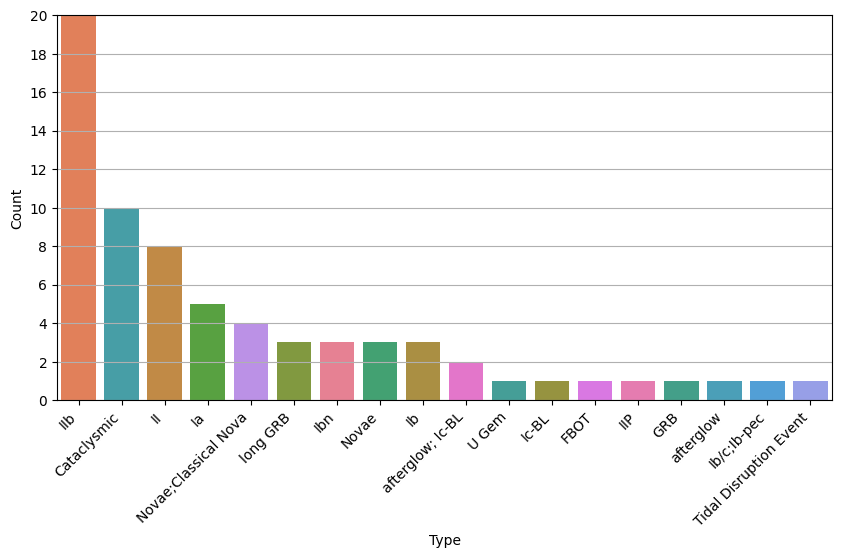

In [195]:
from matplotlib.ticker import MaxNLocator
type_counts = df_rates['type'].value_counts()
sorted_types = type_counts.index
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.grid(axis='y')
sns.countplot(data=df_rates, x='type', order=sorted_types, palette=colors_dict, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylim(0,20)
# plt.savefig('figures/type_distribution.pdf', bbox_inches='tight')
plt.show()

Rise vs Peak Magnitude

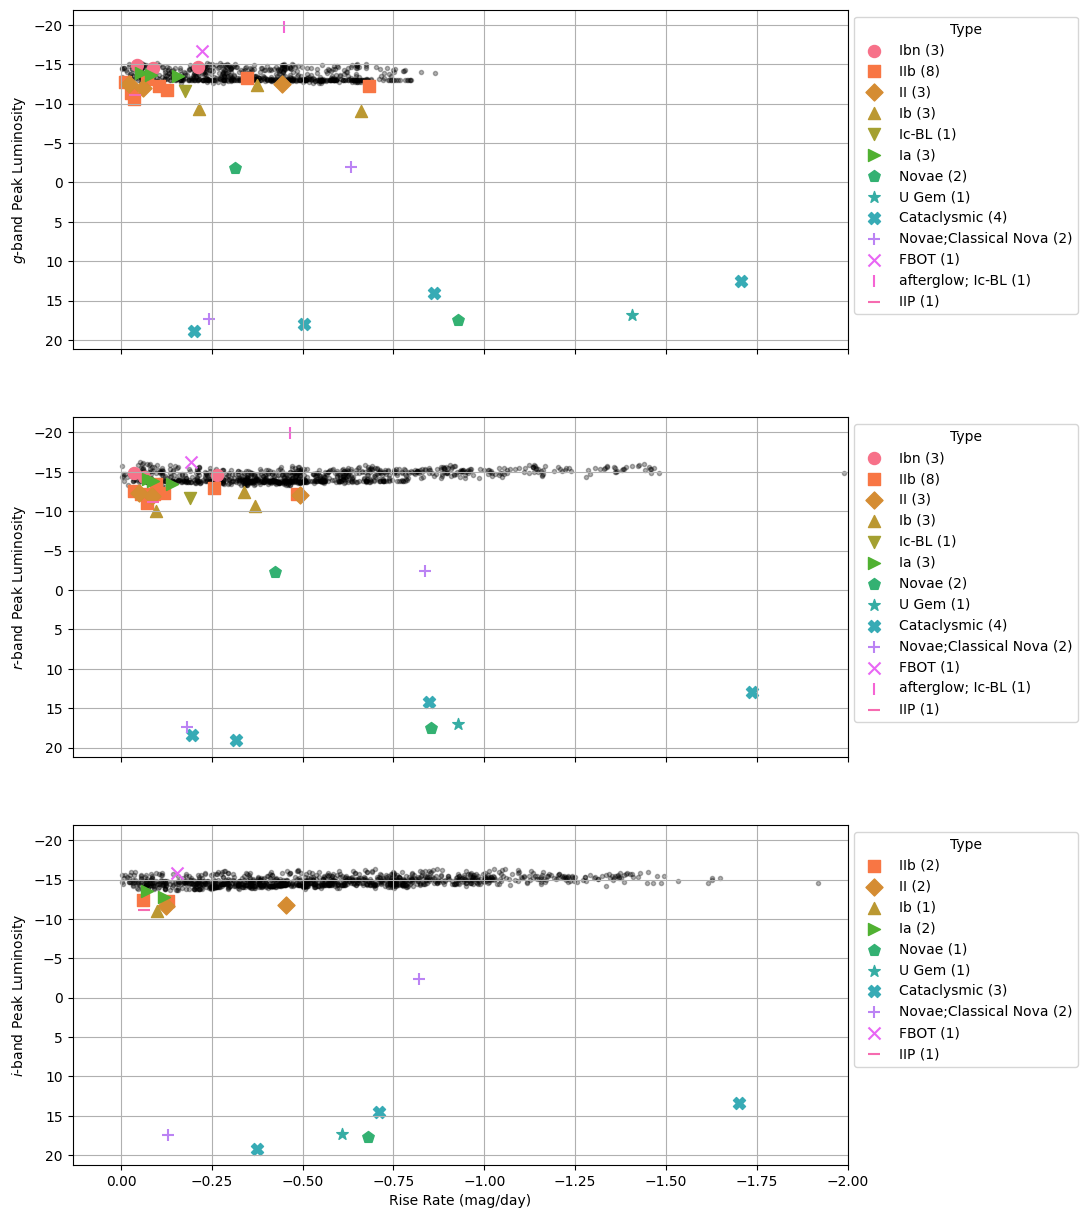

In [227]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True,sharey=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull())]
        if len(df_class) > 0:
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_peak_mag'],
                            color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                             s=75, label=type_)
    

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[df_rates['ztfg_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_rise_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
ax[0].set_xlim(None,-2.0)
#plt.savefig('figures/rise_rate_vs_peak_luminosity.pdf', bbox_inches='tight')
plt.show()

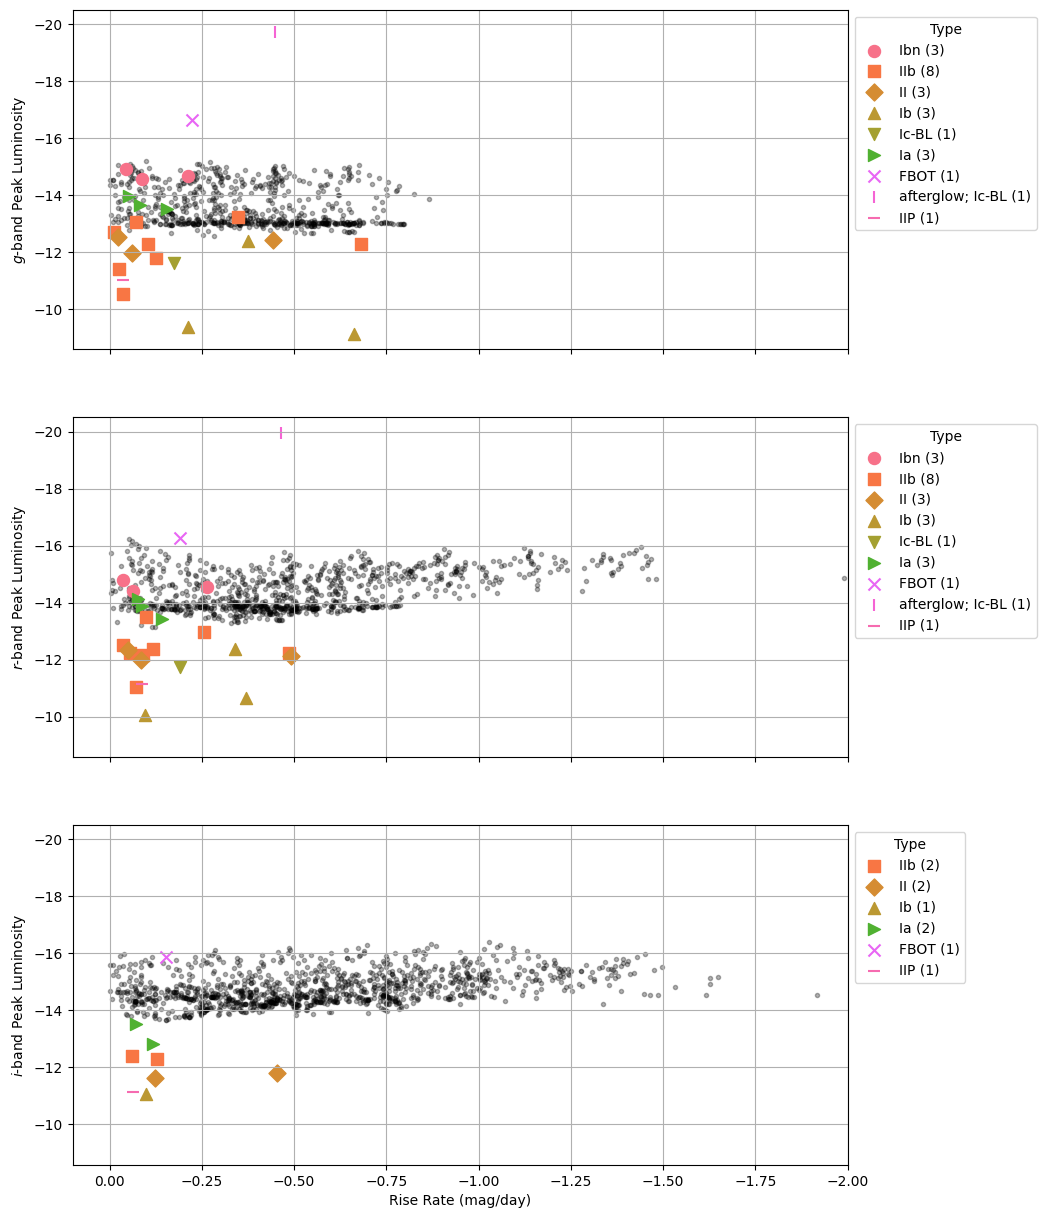

In [230]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_peak_mag'].notnull())]
        if len(df_class) > 0:
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_peak_mag'],
                            color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                             s=75, label=type_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_rise_rate', y=f'{filter}_peak_mag', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_rise_rate', y=f'{filter}_peak_mag', hue='type', style='type', s=150, ax=ax[axi])

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates_far[df_rates_far['ztfg_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates_far[df_rates_far['ztfr_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates_far[df_rates_far['ztfi_rise_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
ax[0].set_xlim(None,-2.0)
#plt.savefig('figures/rise_rate_vs_peak_luminosity_low_z_cutoff.pdf', bbox_inches='tight')
plt.show()

Fade vs Peak Magnitude

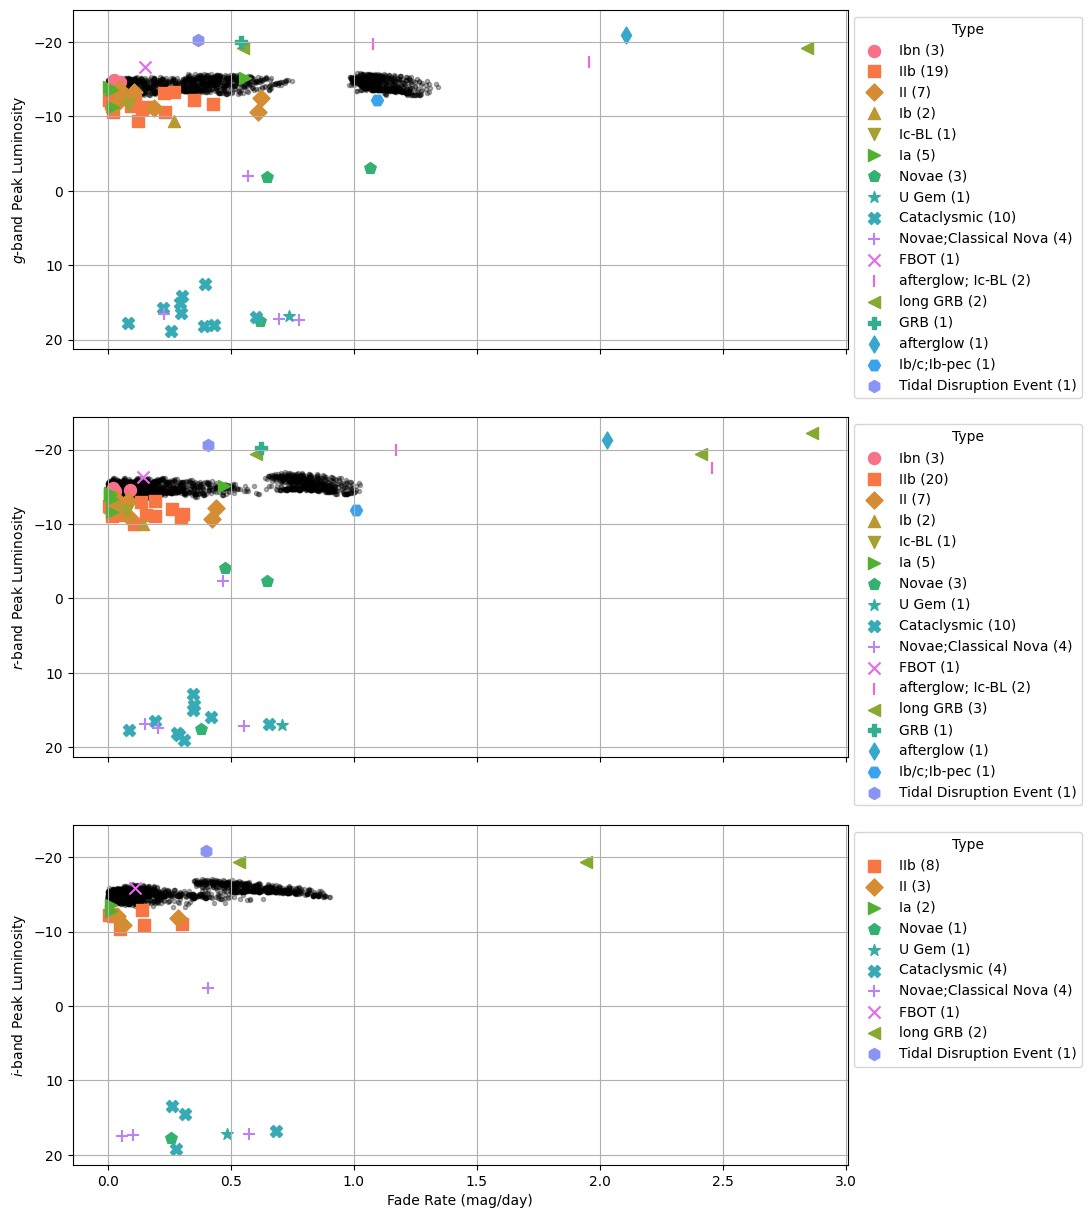

In [231]:

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of fade vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True, sharey=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_fade_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_fade_rate'] > 0)]
        if len(df_class) > 0:
            ax[axi].scatter(df_class[f'{filter}_fade_rate'], df_class[f'{filter}_peak_mag'],
                            color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                             s=75, label=type_)
    

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[df_rates['ztfg_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fade_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Fade Rate (mag/day)");
#plt.savefig('figures/fade_rate_vs_peak_luminosity.pdf', bbox_inches='tight')
plt.show()

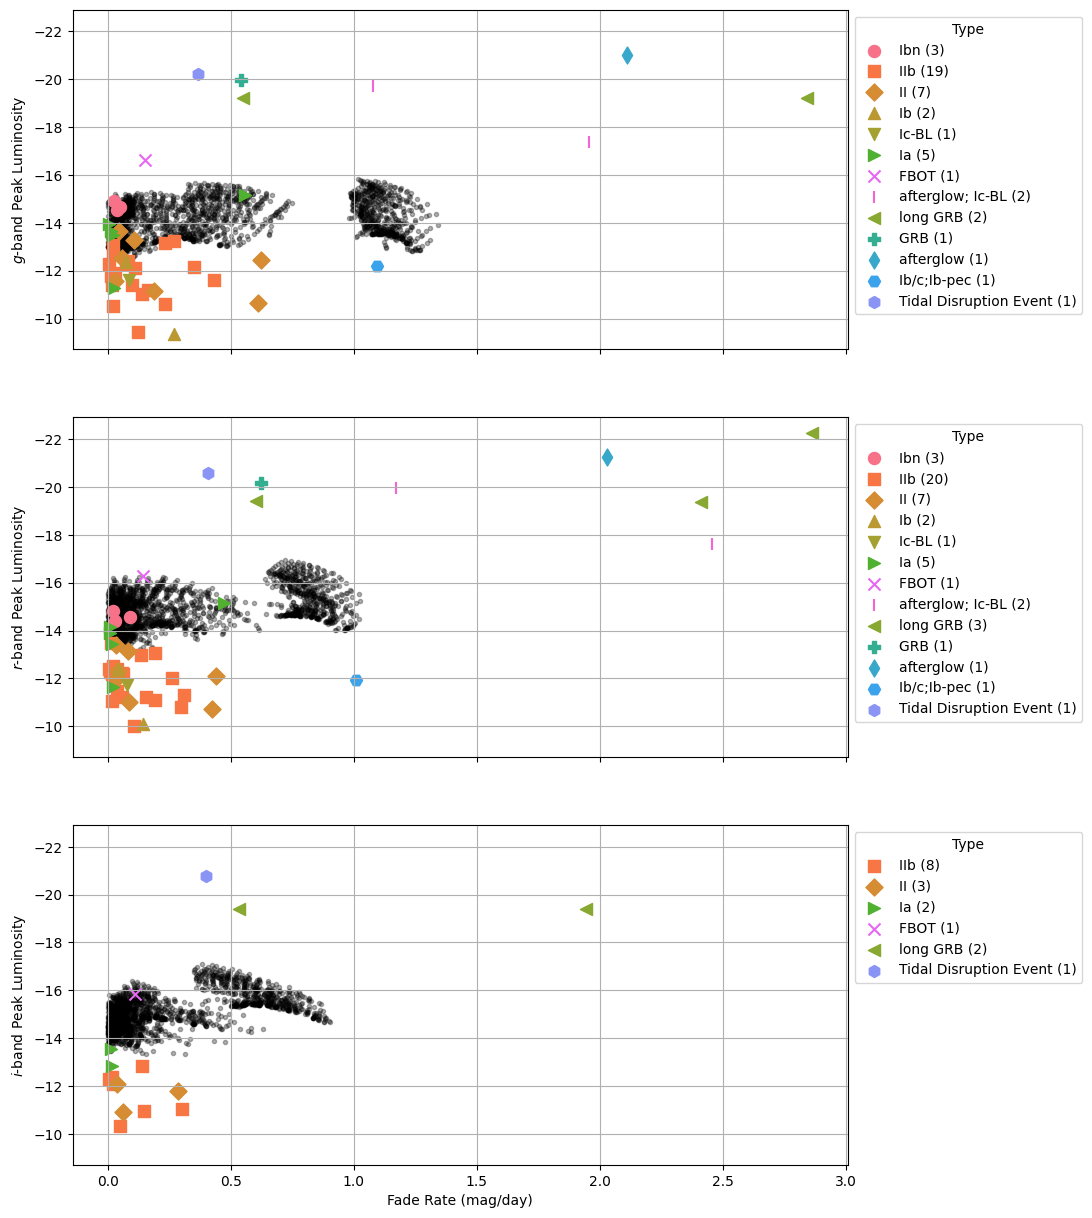

In [232]:

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of fade vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_fade_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_peak_mag'].notnull()) & (df_rates_far[f'{filter}_fade_rate'] > 0)]
        if len(df_class) > 0:
            ax[axi].scatter(df_class[f'{filter}_fade_rate'], df_class[f'{filter}_peak_mag'],
                            color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                             s=75, label=type_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_fade_rate', y=f'{filter}_peak_mag', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_fade_rate', y=f'{filter}_peak_mag', hue='type', style='type', s=150, ax=ax[axi])

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates_far[df_rates_far['ztfg_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates_far[df_rates_far['ztfr_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates_far[df_rates_far['ztfi_fade_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Fade Rate (mag/day)");
#plt.savefig('figures/fade_rate_vs_peak_luminosity_low_z_cutoff.pdf', bbox_inches='tight')
plt.show()

Rise vs Fade

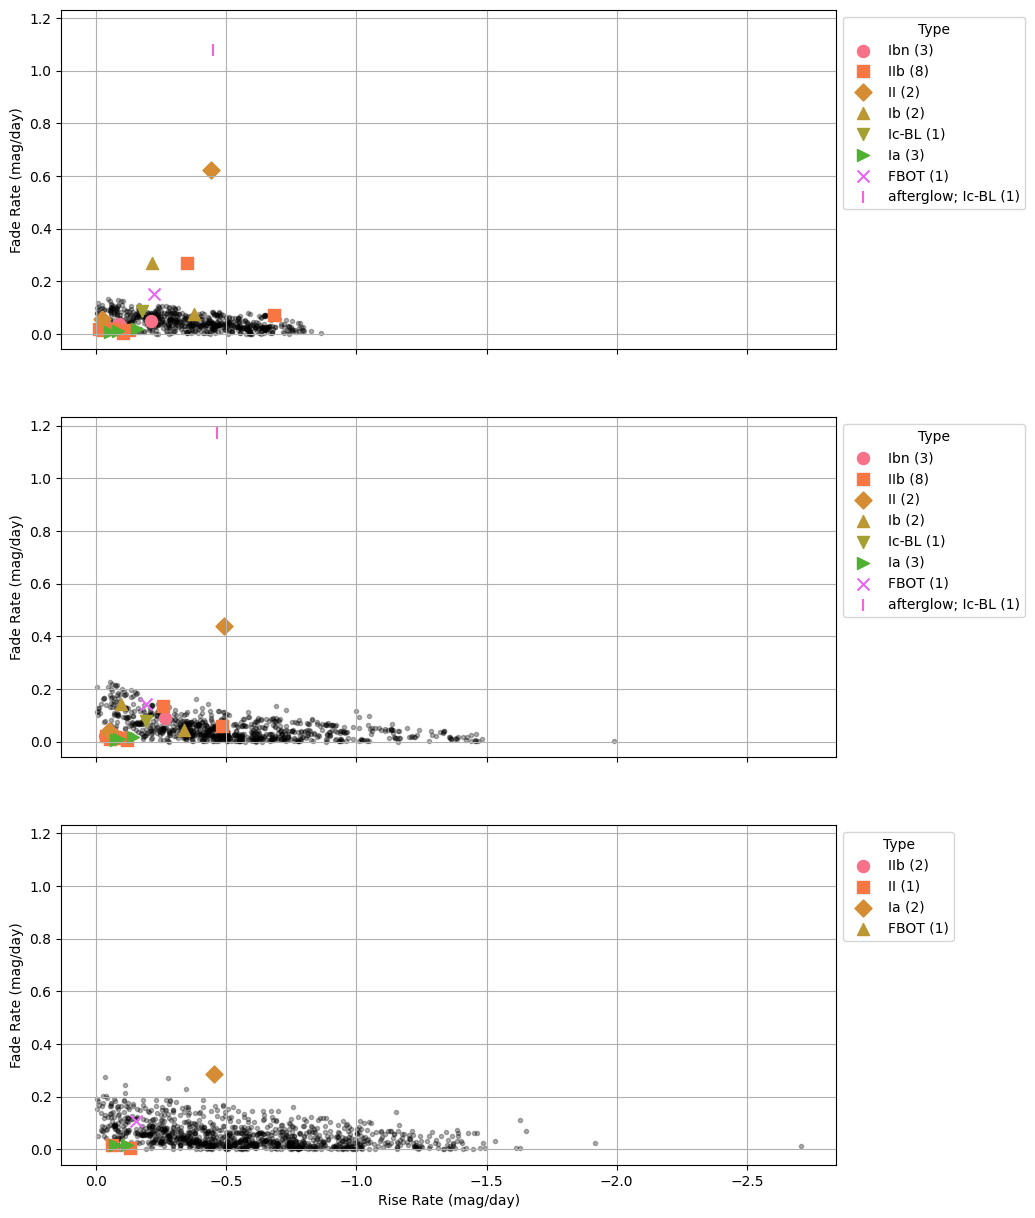

In [169]:

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_fade_rate'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_)]
        if len(df_class) > 0:
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_fade_rate'],
                            color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                             s=75, label=type_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_rise_rate', y=f'{filter}_fade_rate', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_rise_rate', y=f'{filter}_fade_rate', hue='type', style='type', s=150, ax=ax[axi])

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[(df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfg_fade_rate'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[(df_rates['ztfr_rise_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[(df_rates['ztfi_rise_rate'].notnull()) & (df_rates['ztfi_fade_rate'].notnull())]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("Fade Rate (mag/day)"), ax[1].set_ylabel("Fade Rate (mag/day)"), ax[2].set_ylabel("Fade Rate (mag/day)")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
plt.savefig('figures/rise_rate_vs_fade_rate.pdf', bbox_inches='tight')
plt.show()

g-band rise vs r-band rise & g-band fade vs r-band fade

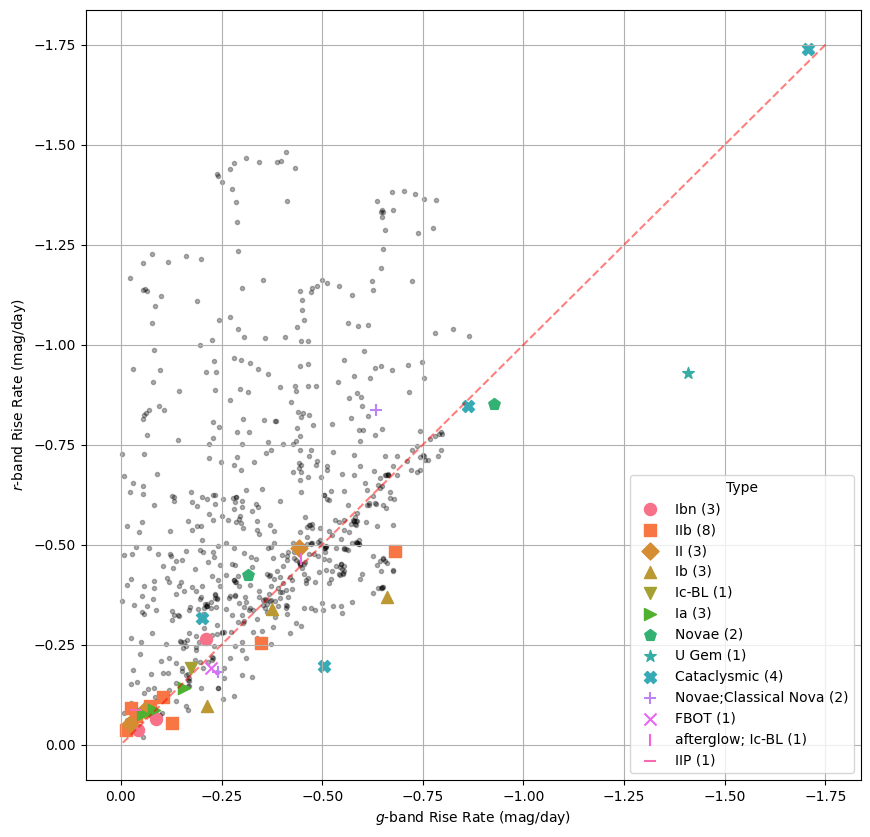

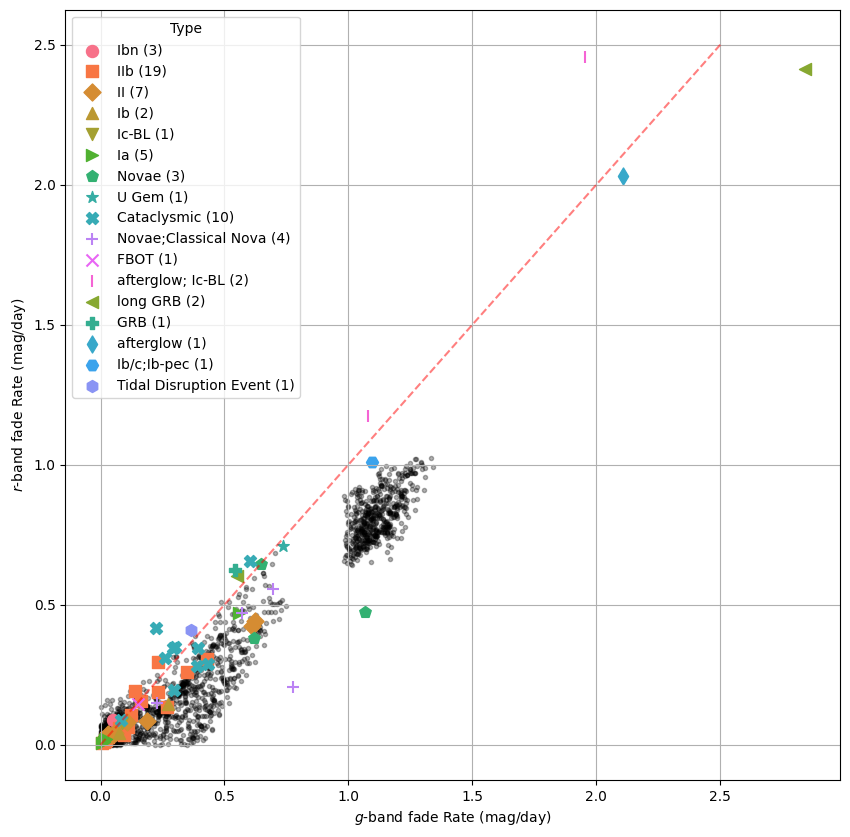

In [226]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), 
                       sharex=True,sharey=True)
ax.grid()
ax.scatter(df_2019[df_2019[f'ztfr_rise_rate'] > -1.75][f'ztfg_rise_rate'], df_2019[df_2019[f'ztfr_rise_rate'] > -1.75][f'ztfr_rise_rate'], alpha=0.3,color='k',marker='.')
ax.plot(np.linspace(-1.75,0,100), np.linspace(-1.75,0,100), color='r', linestyle='--',alpha=0.5)
for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfr_rise_rate'].notnull())]
    if len(df_class) > 0:
        ax.scatter(df_class[f'ztfg_rise_rate'], df_class[f'ztfr_rise_rate'],
                        color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                            s=75, label=type_)

class_counts_ztfg_ztfr = df_rates[(df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfr_rise_rate'].notnull())]['type'].value_counts().to_dict()
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} ({class_counts_ztfg_ztfr[label]})' for label in labels if label in class_counts_ztfg_ztfr]
legend = ax.legend(handles, new_labels, title='Type')#, bbox_to_anchor=(1, 1), loc="upper left")
ax.set_ylabel("$\it{r}$-band Rise Rate (mag/day)"), ax.set_xlabel("$\it{g}$-band Rise Rate (mag/day)");
#plt.savefig('figures/ztfg_rise_rate_vs_ztfr_rise_rate.pdf', bbox_inches='tight')
ax.invert_xaxis(), ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), 
                       sharex=True,sharey=True)
ax.grid()
ax.scatter(df_2019[df_2019[f'ztfr_fade_rate'] > -1.75][f'ztfg_fade_rate'], df_2019[df_2019[f'ztfr_fade_rate'] > -1.75][f'ztfr_fade_rate'], alpha=0.3,color='k',marker='.')
ax.plot(np.linspace(0,2.5,100), np.linspace(0,2.5,100), color='r', linestyle='--',alpha=0.5)
for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_fade_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]
    if len(df_class) > 0:
        ax.scatter(df_class[f'ztfg_fade_rate'], df_class[f'ztfr_fade_rate'],
                        color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                            s=75, label=type_)

class_counts_ztfg_ztfr = df_rates[(df_rates['ztfg_fade_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]['type'].value_counts().to_dict()
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} ({class_counts_ztfg_ztfr[label]})' for label in labels if label in class_counts_ztfg_ztfr]
legend = ax.legend(handles, new_labels, title='Type')#, bbox_to_anchor=(1, 1), loc="upper left")
ax.set_ylabel("$\it{r}$-band fade Rate (mag/day)"), ax.set_xlabel("$\it{g}$-band fade Rate (mag/day)");
#plt.savefig('figures/ztfg_fade_rate_vs_ztfr_fade_rate.pdf', bbox_inches='tight')
#ax.invert_xaxis(), ax.invert_yaxis()
plt.show()

In [95]:
def metric_distance(object, model_data):
    '''
    Finds the average distance between an object and model data. 
    
    Args:
    object (tuple): tuple containing an object's two metrics (x,y)
    model_data (list): list of tuples containing the model data's metrics (x,y)
    
    Returns:
    distance (float): average distance between object and model_data
    '''
    distance_array = np.array([np.sqrt((object[0] - model[0])**2 + (object[1] - model[1])**2) for model in model_data])
    distance_array = distance_array[~np.isnan(distance_array)]
    # print(distance_array)
    distance = np.mean(distance_array)
    return distance


In [96]:
# model_risepeak_list = list(zip(df_2019['ztfg_rise_rate'], df_2019['ztfg_peak_mag']))
# objects_risepeak_list = list(zip(df_rates['ztfg_rise_rate'], df_rates['ztfg_peak_mag']))
# # print(objects_risepeak_list)
# # print(df_risepeak['obj_id'])
# distance_risepeak = {obj: metric_distance(obj_data, model_risepeak_list) for obj, obj_data in zip(obj, objects_risepeak_list)}

In [100]:
for filt in ['ztfg', 'ztfr', 'ztfi']:
    model_risepeak_list = list(zip(df_2019[f'{filt}_rise_rate'], df_2019[f'{filt}_peak_mag']))
    objects_risepeak_list = list(zip(df_rates[f'{filt}_rise_rate'], df_rates[f'{filt}_peak_mag']))
    distance_risepeak = {obj: metric_distance(obj_data, model_risepeak_list) for obj, obj_data in zip(obj, objects_risepeak_list)}
    df_rates[f'{filt}_risepeak_distance'] = distance_risepeak.values() 
    
    model_fadepeak_list = list(zip(df_2019[f'{filt}_fade_rate'], df_2019[f'{filt}_peak_mag']))
    objects_fadepeak_list = list(zip(df_rates[f'{filt}_fade_rate'], df_rates[f'{filt}_peak_mag']))
    distance_fadepeak = {obj: metric_distance(obj_data, model_fadepeak_list) for obj, obj_data in zip(obj, objects_fadepeak_list)}
    df_rates[f'{filt}_fadepeak_distance'] = distance_fadepeak.values()

/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-pac

In [101]:
df_rates

,obj_id,type,redshift,ztfg_rise_duration,ztfg_rise_rate,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,...,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,ztfg_risepeak_distance,ztfr_risepeak_distance,ztfi_risepeak_distance,ztfg_fadepeak_distance,ztfr_fadepeak_distance,ztfi_fadepeak_distance
0,ZTF18aakuewf,Ibn,0.063600,3.898491,-0.212266,4.198375,-0.263955,NaN,NaN,1.999226,...,4.198375,-14.544391,NaN,NaN,1.162235,0.721855,NaN,1.023476,0.766789,NaN
1,ZTF18aalrxas,IIb,0.058200,1.961364,-0.347913,2.059432,-0.255482,NaN,NaN,1.961364,...,2.059432,-12.955816,NaN,NaN,0.619257,1.510886,NaN,1.023306,1.837925,NaN
2,ZTF18abffyqp,II,0.031000,0.950871,-0.022003,2.502293,-0.051005,NaN,NaN,1.951789,...,2.502293,-12.327379,NaN,NaN,1.145747,2.159517,NaN,1.602506,2.465336,NaN
3,ZTF18abvkmgw,Ib,0.038470,4.277578,-0.375830,4.730358,-0.339628,NaN,NaN,1.989848,...,4.730358,-12.389784,NaN,NaN,1.220884,2.057366,NaN,1.750157,2.403566,NaN
4,ZTF18abwkrbl,IIb,0.009990,2.837926,-0.682061,3.620802,-0.485527,NaN,NaN,1.957190,...,3.620802,-12.221934,NaN,NaN,1.347921,2.219221,NaN,1.836652,2.568256,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,ZTF23aarlxdf,Novae;Classical Nova,-0.001000,NaN,NaN,NaN,NaN,NaN,NaN,1.986957,...,0.000000,16.812194,0.0,17.296574,NaN,NaN,NaN,30.638555,31.577243,32.328298
65,ZTF23aaxeacr,afterglow; Ic-BL,0.360000,NaN,NaN,NaN,NaN,NaN,NaN,0.170266,...,0.000000,-17.596908,NaN,NaN,NaN,NaN,NaN,3.676214,3.594065,NaN
66,ZTF23aaxzvrr,Novae;Classical Nova,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.999967,...,0.000000,17.137527,0.0,17.216648,NaN,NaN,NaN,31.293779,31.903375,32.250186
67,ZTF23abobwsd,IIb,0.024000,NaN,NaN,NaN,NaN,NaN,NaN,1.978073,...,0.000000,-12.180304,0.0,-12.100538,NaN,NaN,NaN,2.007180,2.609266,2.944909


<Axes: xlabel='ztfg_fadepeak_distance', ylabel='Count'>

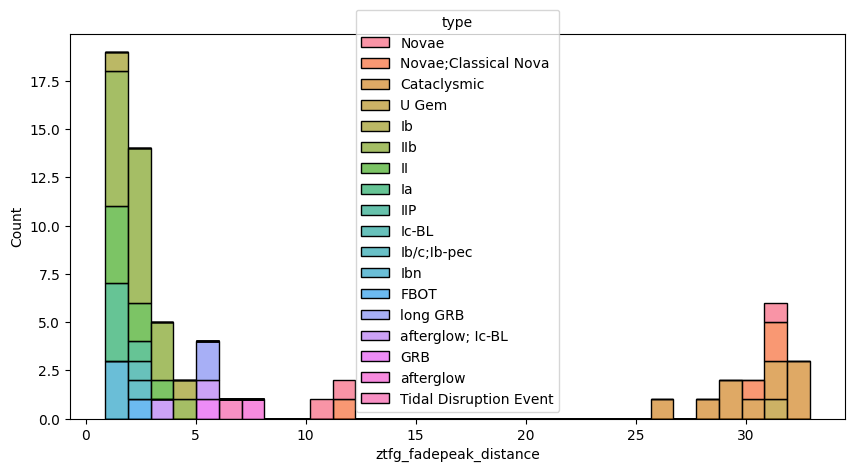

In [102]:
sns.set_palette('colorblind')
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data=df_rates.sort_values('redshift'), x='ztfg_fadepeak_distance', hue='type', multiple='stack', ax=ax, bins=31)

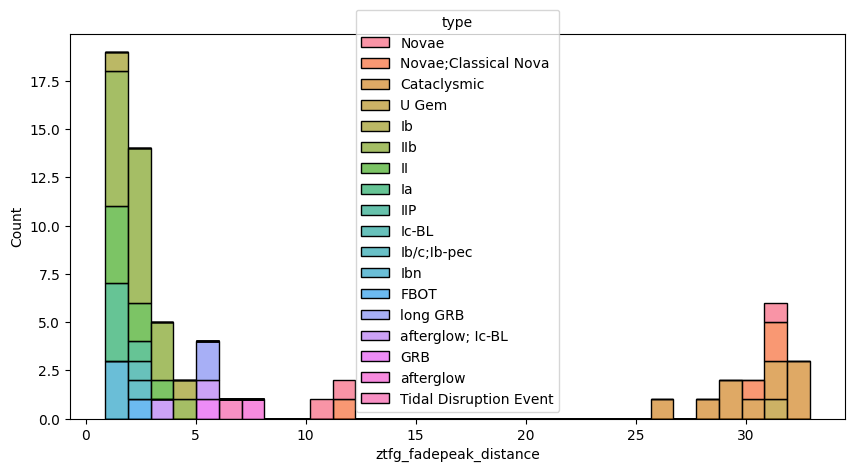

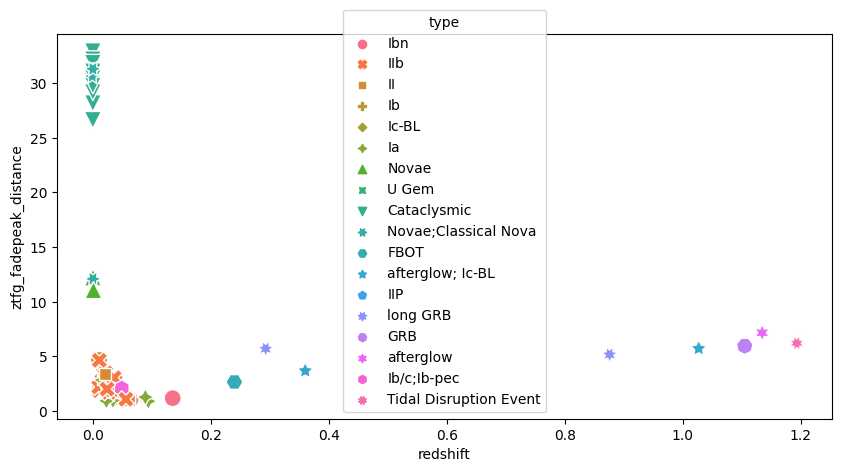

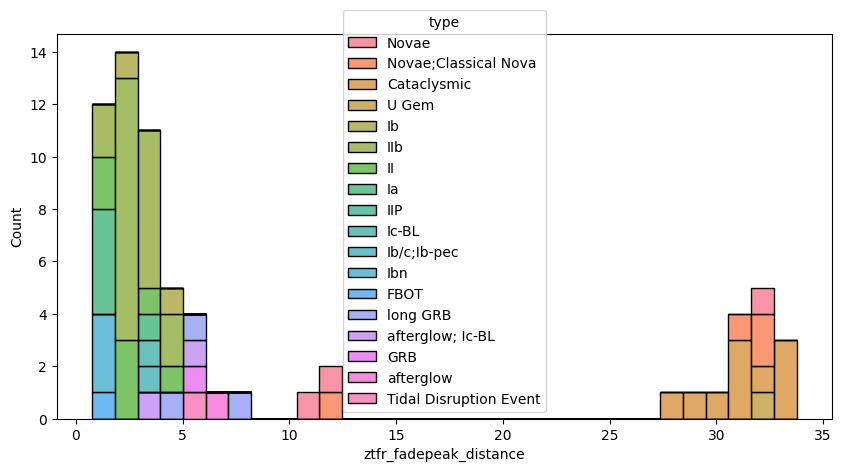

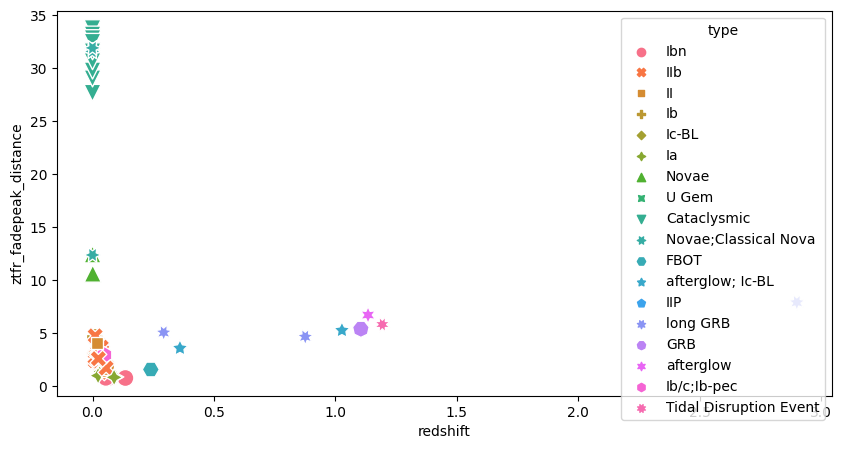

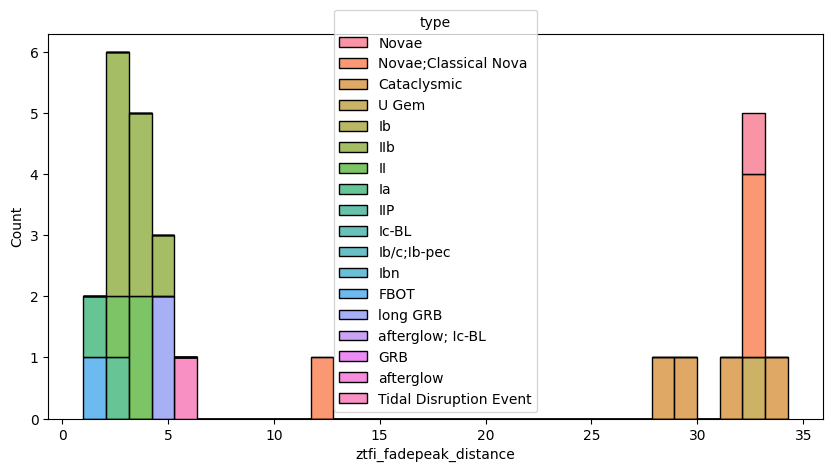

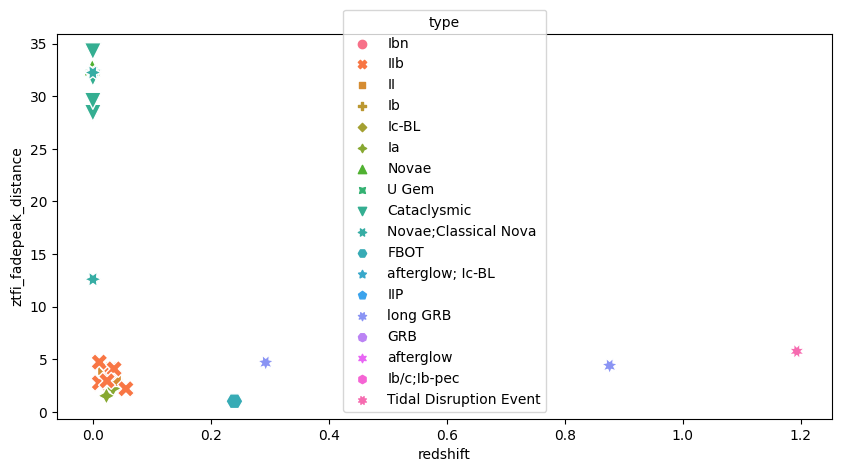

In [110]:
# for filt in ['ztfg', 'ztfr', 'ztfi']:
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#     sns.histplot(data=df_rates.sort_values('redshift'), x=f'{filt}_fadepeak_distance', hue='type', multiple='stack', ax=ax, bins=31)
#     plt.show()
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#     sns.scatterplot(data=df_rates, x='redshift', y=f'{filt}_fadepeak_distance', hue='type', style='type', s=150, ax=ax)
#     #ax.set_xlim(None, 0.25);
#     plt.show()


((-0.01, 0.25), (-0.05, 35.0))

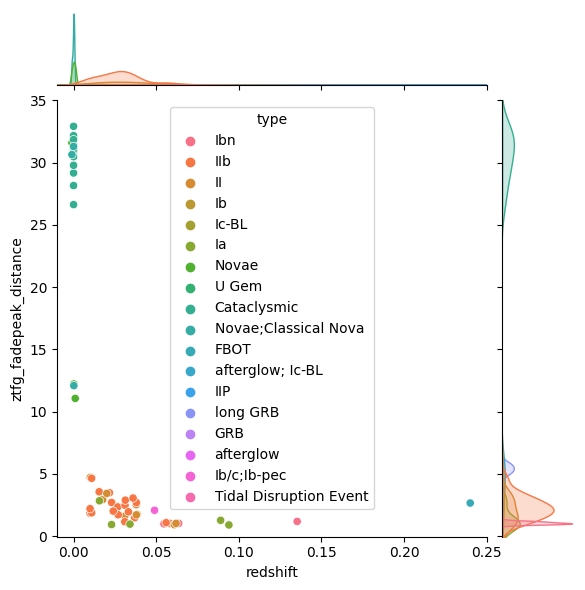

In [157]:
JG1 = sns.jointplot(data=df_rates, x='redshift', y='ztfg_fadepeak_distance', hue='type',markers='type')
JG1.ax_marg_x.set_xlim(-0.01,0.25), JG1.ax_marg_y.set_ylim(-0.05,35)
# JG1.ax_marg_x.set_xlim(-0.3,None), JG1.ax_marg_y.set_ylim(-1,None)

/tmp/ipykernel_268447/2732709663.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


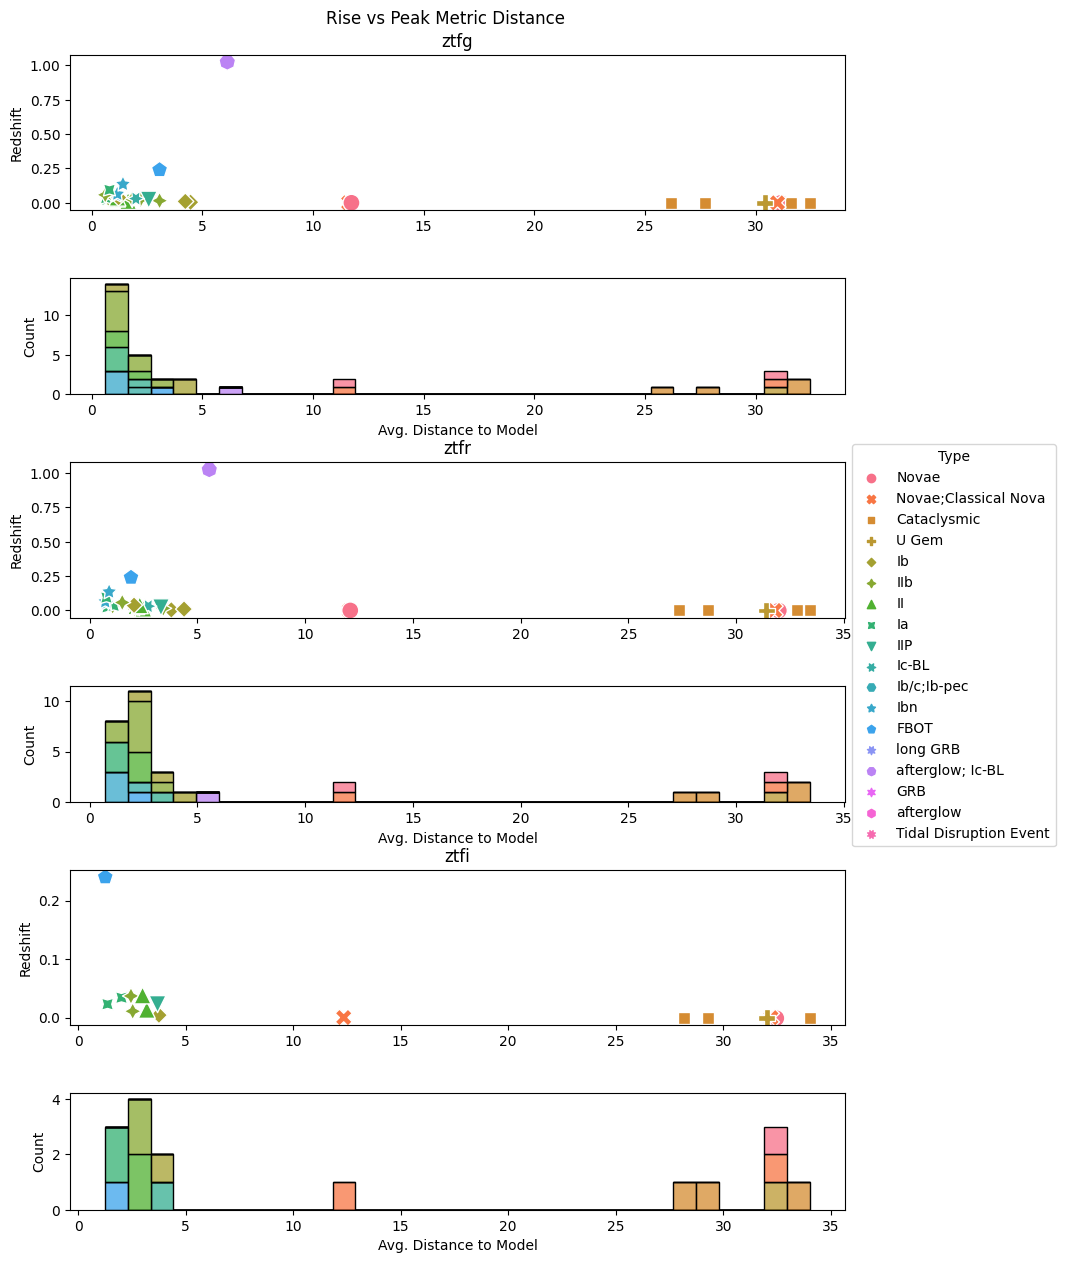

In [147]:
filters = ['ztfg', 'ztfr', 'ztfi'] 
y_column = 'redshift'
x_columns = {
    'ztfg': 'ztfg_risepeak_distance',
    'ztfr': 'ztfr_risepeak_distance',
    'ztfi': 'ztfi_risepeak_distance'
}

fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(6, 1, height_ratios=[4,3] * 3, hspace=0.5)

handles, labels = [], []

for i, filt in enumerate(filters):

    x_column = x_columns[filt]

    ax_scatter = fig.add_subplot(gs[i*2, 0])
    scatter = sns.scatterplot(data=df_rates.sort_values('redshift'), x=x_column, y=y_column, hue='type', style='type', s=150, ax=ax_scatter)
    ax_scatter.set_title(f'{filt}')
    ax_scatter.set_ylabel('Redshift')
    ax_scatter.set_xlabel(None)

    if i == 0:
        handles, labels = ax_scatter.get_legend_handles_labels()
    ax_scatter.legend_.remove()
    
    ax_hist = fig.add_subplot(gs[i*2+1, 0], sharex=ax_scatter)
    #ax_hist.hist(df_rates[x_column], bins=30, color='gray', alpha=0.7)
    sns.histplot(data=df_rates.sort_values('redshift'), x=x_column, hue='type', multiple='stack', ax=ax_hist, bins=31,legend=False)
    ax_hist.set_xlabel('Avg. Distance to Model')
    #ax_hist.set_ylabel('Count')

fig.legend(handles=handles, labels=labels, title='Type', bbox_to_anchor=(0.9, 0.625), loc="upper left")
fig.suptitle('Rise vs Peak Metric Distance', y=0.91)
plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.show()

/tmp/ipykernel_268447/125871299.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


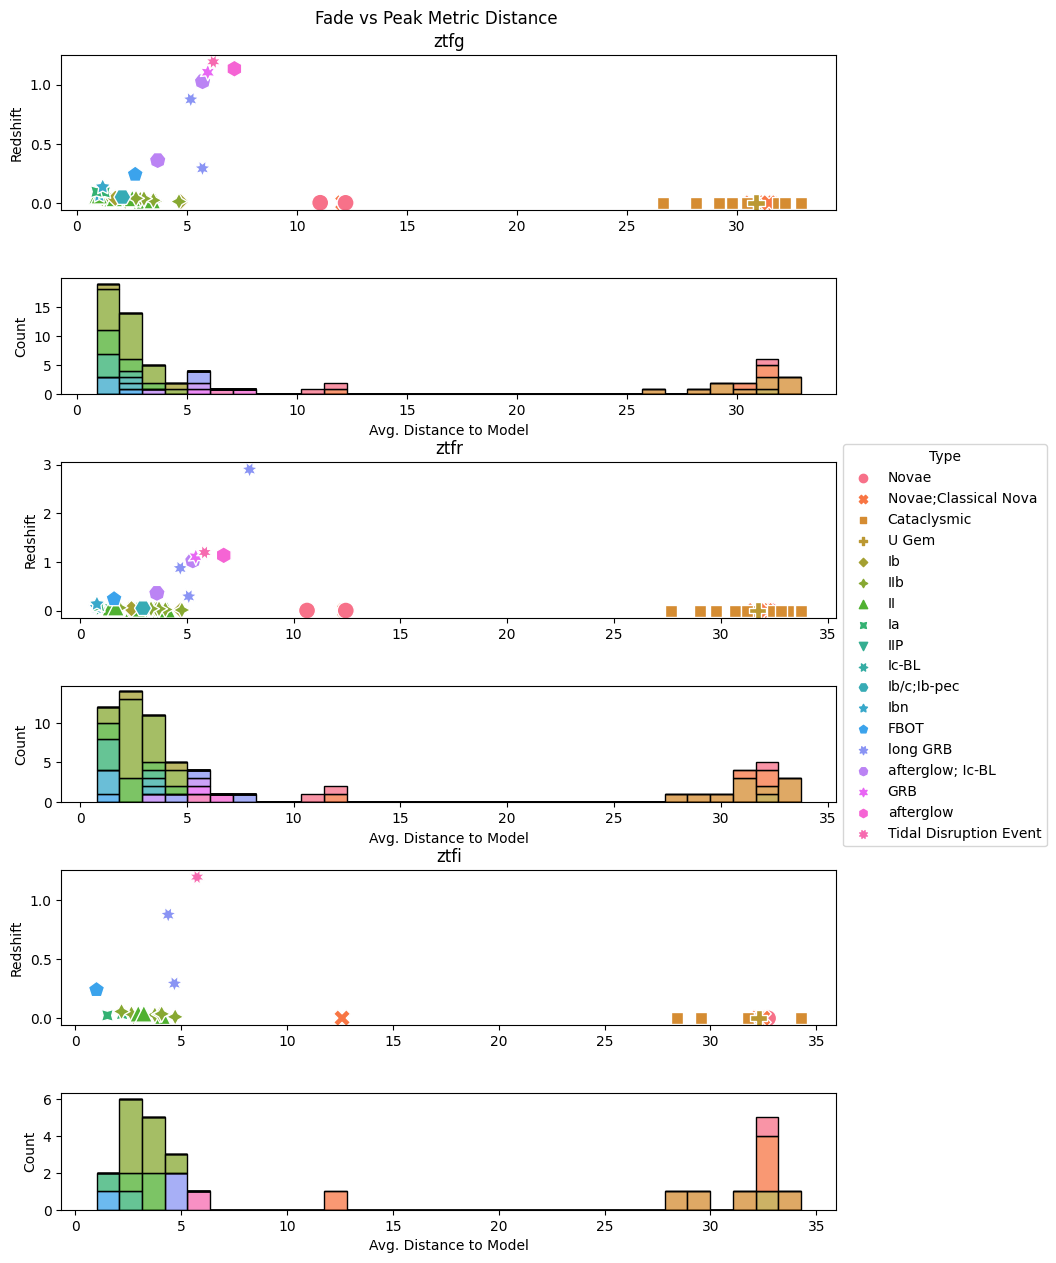

In [148]:
filters = ['ztfg', 'ztfr', 'ztfi'] 
y_column = 'redshift'
x_columns = {
    'ztfg': 'ztfg_fadepeak_distance',
    'ztfr': 'ztfr_fadepeak_distance',
    'ztfi': 'ztfi_fadepeak_distance'
}

fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(6, 1, height_ratios=[4,3] * 3, hspace=0.5)

handles, labels = [], []

for i, filt in enumerate(filters):

    x_column = x_columns[filt]

    ax_scatter = fig.add_subplot(gs[i*2, 0])
    scatter = sns.scatterplot(data=df_rates.sort_values('redshift'), x=x_column, y=y_column, hue='type', style='type', s=150, ax=ax_scatter)
    ax_scatter.set_title(f'{filt}')
    ax_scatter.set_ylabel('Redshift')
    ax_scatter.set_xlabel(None)

    if i == 0:
        handles, labels = ax_scatter.get_legend_handles_labels()
    ax_scatter.legend_.remove()
    
    ax_hist = fig.add_subplot(gs[i*2+1, 0], sharex=ax_scatter)
    #ax_hist.hist(df_rates[x_column], bins=30, color='gray', alpha=0.7)
    sns.histplot(data=df_rates.sort_values('redshift'), x=x_column, hue='type', multiple='stack', ax=ax_hist, bins=31,legend=False)
    ax_hist.set_xlabel('Avg. Distance to Model')
    #ax_hist.set_ylabel('Count')

fig.legend(handles=handles, labels=labels, title='Type', bbox_to_anchor=(0.9, 0.625), loc="upper left")

plt.tight_layout(rect=[0, 0, 0.85, 1])
fig.suptitle('Fade vs Peak Metric Distance', y=0.91)
plt.show()